In [68]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Text Classification

We did not do much classification in class although it is relevant in many industrial settings, for example:
- spam detection
- sentiment analysis
- hate speech detection

There are also several theoretical NLP problems that are framed as classification, such as Natural Language Inference.

Because it is very basic, it gives you freedom to use any NLP method:
- bag of words (not really seen in class)
- word embeddings
- LSTM/RNN
- fine-tuned Transformer Encoder (e.g. BERT)...
- ...with full fine-tuning or parameter efficient fine-tuning (e.g. LoRA)
- prompted LLM (e.g. Llama)...
- ...with standard prompting or chain of thought...
- ...with or without In-Context Learning examples

For this homework, we will study the detection of automatically generated text (more specifically, automatically generated research papers), based on the work of [Liyanage et al. 2022 "A Benchmark Corpus for the Detection of Automatically Generated Text in Academic Publications"](https://aclanthology.org/2022.lrec-1.501)

> Automatic text generation based on neural language models has achieved performance levels that make the generated text almost indistinguishable from those written by humans. Despite the value that text generation can have in various applications, it can also be employed for malicious tasks. The diffusion of such practices represent a threat to the quality of academic publishing. To address these problems, we propose in this paper two datasets comprised of artificially generated research content: a completely synthetic dataset and a partial text substitution dataset. In the first case, the content is completely generated by the GPT-2 model after a short prompt extracted from original papers. The partial or hybrid dataset is created by replacing several sentences of abstracts with sentences that are generated by the Arxiv-NLP model. We evaluate the quality of the datasets comparing the generated texts to aligned original texts using fluency metrics such as BLEU and ROUGE. The more natural the artificial texts seem, the more difficult they are to detect and the better is the benchmark. We also evaluate the difficulty of the task of distinguishing original from generated text by using state-of-the-art classification models.

# Installation and imports

Hit `Ctrl+S` to save a copy of the Colab notebook to your drive

Run on Google Colab GPU:
- Connect
- Modify execution
- GPU

![image.png](https://paullerner.github.io/aivancity_nlp/_static/colab_gpu.png)

In [1]:
!nvidia-smi

Wed Feb 26 15:42:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----


T4 GPU (on Google Colab) offers 15GB of memory. This should be enough to run inference and fine-tune LLMs of a few billion parameters (or less, obviously)

Note, in `float32`, 1 parameter = 4 bytes so a LLM of 1B parameters holds 4GB of RAM.
But for full fine-tuning, you will need to store gradient activations (without gradient checkpointing) and optimizer states (with optimizers like Adam).

Turn to quantization for cheap inference of larger models or to Parameter Efficient Fine-Tuning for full-fine tuning of LLMs of a few billion parameters.

Much simpler solution: stick to smaller models of hundred of millions of parameters (e.g. BERT, GPT-2, T5).
You're not here to beat the state of the art but to learn NLP.

In [2]:
import torch
import os

In [3]:
assert torch.cuda.is_available(), "Connect to GPU and try again"

# Data
We will use the Hybrid subset of Vijini et al. in which some sentences of human-written abstracts where replaced by automatically-generated text. Experiments on the fully-generated subsets (or any other dataset) may provide bonus points (à faire)

There are no train-test split provided in the paper but we keep 80% to train and 20% to test, following Vijini et al.

In [4]:
import shutil

# Remplacez 'nom_du_dossier' par le chemin du dossier que vous souhaitez supprimer
dossier_a_supprimer = 'GeneratedTextDetection-main'

try:# Supprimer le dossier et tout son contenu
  shutil.rmtree(dossier_a_supprimer)
  print(f"Le dossier {dossier_a_supprimer} a été supprimé avec succès.")
except Exception:
  print(f"{dossier_a_supprimer} n\'existe peut être pas")
finally:
  print('téléchargemet du dataset')

GeneratedTextDetection-main n'existe peut être pas
téléchargemet du dataset


In [5]:
!wget https://github.com/vijini/GeneratedTextDetection/archive/refs/heads/main.zip
!unzip main

--2025-02-26 15:42:04--  https://github.com/vijini/GeneratedTextDetection/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/vijini/GeneratedTextDetection/zip/refs/heads/main [following]
--2025-02-26 15:42:04--  https://codeload.github.com/vijini/GeneratedTextDetection/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ] 800.25K  2.04MB/s    in 0.4s    

2025-02-26 15:42:05 (2.04 MB/s) - ‘main.zip’ saved [819461]

Archive:  main.zip
ab034465f857a93212a894fe598edb749345b6ff
   creating: GeneratedTextDetection-main/
  inflating: Ge

In [6]:
from pathlib import Path

In [7]:
root = Path("GeneratedTextDetection-main/Dataset/Hybrid_AbstractDataset")

In [8]:
train_texts, train_labels, test_texts, test_labels = [], [], [], []
for path in root.glob("*.txt"):
    with open(path, 'rt') as file:
        text = file.read()
        text = text.lstrip('\ufeff')
    label = int(path.name.endswith("generatedAbstract.txt"))
    doc_id = int(path.name.split("_")[0].split(".")[-1])
    if doc_id < 10522:
        test_texts.append(text)
        test_labels.append(label)
    else:
        train_texts.append(text)
        train_labels.append(label)

In [9]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(160, 160, 40, 40)

In [10]:
train_texts[0]

'Machine learning in medical imaging during clinical routine is impaired by changes in scan- ner protocols, hardware, or policies resulting in a heterogeneous set of acquisition settings. When training a deep learning model on an initial static training set, model performance and reliability suffer from changes of acquisition characteristics as data and targets may become inconsistent. Continual learning can help to adapt models to the changing environ- ment by training on a continuous data stream. However, continual manual expert labelling of medical imaging requires substantial effort. Thus, ways to use labelling resources ef- ficiently on a well chosen sub-set of new examples is necessary to render this strategy feasible. Here, we propose an integrated toolkit for automatic annotation of medical imaging , based on a deep embeddings framework for biomedical data, and present a method to automatically infer such annotation results using the full medical image corpus. The approach auto

In [11]:
train_labels[0]

1

In [12]:
train_texts[10]

'Public policies that supply public goods, especially those involve collaboration by limiting individual liberty, always give rise to controversies over governance legitimacy. Multi-Agent Reinforcement Learning (MARL) methods are appropriate for supporting the legitimacy of the public policies that supply public goods at the cost of individual interests. Among these policies, the inter-regional collaborative pandemic control is a prominent example, which has become much more important for an increasingly inter-connected world facing a global pandemic like COVID-19. Different patterns of collaborative strategies have been observed among different systems of regions, yet it lacks an analytical process to reason for the legitimacy of those strategies. In this paper, we use the inter-regional collaboration for pandemic control as an example to demonstrate the necessity of MARL in reasoning, and thereby legitimizing policies enforcing such inter-regional collaboration. Exper- imental result

In [13]:
train_labels[10]

0

# Good luck!

It's now up to you to solve the problem. You are free to choose any NLP method (cf. the list I gave above)
but you should motivate your choice.
You can also compare several methods to get bonus points. (compare 3 méthode)

# Submission instructions


**Deadline: Thursday 27th of February 23:59 (Paris CEST)** (strict deadline, 5 points malus per day late, so 4 days late means 0/20)

This is a **group work** of **3 members**.

You will have to submit your **code** and a **report** which will be graded (instructions below) by email to lerner@isir.upmc.fr.

The homework (continuous assessment) will account for 50% of your final grade.

## Report

The report should be **a single .pdf file of max. 4 pages** (concision is key).
Please name the pdf with the name of your group as written in the spreadsheet https://docs.google.com/spreadsheets/d/1UbApMhPC_wof-GoByjkV7kgD5YMbjcFFPqPUCB0YRtQ/edit?usp=sharing for example `ABC.pdf`.

It should follow the following structure:

### Introduction
A few sentences placing the work in context. Limit it to a few paragraphs at most; since your report is based on Vijini et al., you don’t have to motivate that work. However, it should be clear enough what Vijini et al. is
about and what its contributions are.

### Methodology

Describe the methods you are using to tackle the problem and motivate it: why this method and not another?  
What are its advantages and inconvenients?  
What experiment are you running to measure the efficiency or effectiveness of your method to tackle the problem?

#### Model Descriptions
Describe the models you used, including the architecture, learning objective and the number of parameters.

#### Datasets
Describe the datasets you used and how you obtained them.

#### Hyperparameters
Describe how you set the hyperparameters and what was the source for their value (e.g., paper, code, or your guess).

#### Implementation
Describe whether you use existing code or write your own code.

#### Experimental Setup
Explain how you ran your experiments, e.g. the CPU/GPU resources.

### Results
Start with a high-level overview of your results. Keep this
section as factual and precise as possible.
Logically
group related results into sections.

Remember to add plots and diagrams to illustrate your methods or results if necessary.



### Discussion

Describe which parts of your project were difficult or took much more time than you expected.


### Contributions

You should state the contributions of each member of the group.



## Code

You can submit your code either as:

- single .zip file with your entire source code (e.g. several .py files)
- link to a GitHub/GitLab repository (in this case, **include the link in your .pdf report**)
- link to a Google Colab Notebook (your code may be quite simple so it may fit in a single notebook;
  likewise, in this case, **include the link in your .pdf report**)

# Let's start

# Installation and Import

In [14]:
!pip install lazypredict
!pip install tensorflow

In [15]:
#general
from lazypredict.Supervised import LazyClassifier
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc ,precision_recall_fscore_support, accuracy_score

#process
import psutil
import time
import subprocess


#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout,Bidirectional
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import Callback


#torch & transformer
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [16]:
import nltk

#nltk local download
nltk_data_path = '/content/nltk_data'
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
print("Chemins de recherche de NLTK :", nltk.data.path)

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...


Chemins de recherche de NLTK : ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/content/nltk_data']


[nltk_data]   Unzipping corpora/stopwords.zip.


# Data analysis

## Distribution: balanced data?

In [17]:
# Afficher la distribution des classes dans les ensembles d'entraînement et de test
train_distribution = Counter(train_labels)
test_distribution = Counter(test_labels)

print("Data distribution in training set :", train_distribution)
print("Data distribution in test set :", test_distribution)


Data distribution in training set : Counter({1: 80, 0: 80})
Data distribution in test set : Counter({1: 20, 0: 20})


## conclusion: perfectly balanced dataset

# Data Preprocessing

In [18]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Mettre en minuscules
    text = text.lower()

    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokeniser le texte
    tokens = word_tokenize(text)

    # Supprimer les stopwords
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [19]:
tokenized_train_texts = [preprocess_text(text) for text in train_texts]
print("Tokens prétraités :", tokenized_train_texts[0][:10])

Tokens prétraités : ['machine', 'learning', 'medical', 'imaging', 'clinical', 'routine', 'impaired', 'changes', 'scan', 'ner']


# Features extraction

###  bag of word

In [20]:
# Instanciation du vectorizer
vectorizer_bow = CountVectorizer()

# Transformation des textes d'entraînement et de test en matrices de comptage
X_train_bow = vectorizer_bow.fit_transform(train_texts)
X_test_bow = vectorizer_bow.transform(test_texts)

print("Taille de la matrice d'entraînement (bag-of-words) :", X_train_bow.shape)


Taille de la matrice d'entraînement (bag-of-words) : (160, 3180)


### Tf-idf

In [21]:
# Instanciation du vectorizer TF-IDF
vectorizer_tfidf = TfidfVectorizer()

# Transformation des textes d'entraînement et de test en matrices TF-IDF
X_train_tfidf = vectorizer_tfidf.fit_transform(train_texts)
X_test_tfidf = vectorizer_tfidf.transform(test_texts)

print("Taille de la matrice d'entraînement (TF-IDF) :", X_train_tfidf.shape)


Taille de la matrice d'entraînement (TF-IDF) : (160, 3180)


# Lazy predict to compare model

In [22]:

def training(X_train,X_test, Y_train, Y_test):
    print("Utilisation du CPU avant entraînement:", psutil.cpu_percent(interval=1), "%")
    print("Mémoire virtuelle avant entraînement:", psutil.virtual_memory())

    #training
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train.toarray(), X_test.toarray(), Y_train, Y_test)


    # Afficher l'utilisation finale du CPU et de la mémoire
    print("Utilisation du CPU après entraînement:", psutil.cpu_percent(interval=1), "%")
    print("Mémoire virtuelle après entraînement:", psutil.virtual_memory())


    return models, predictions

## TFidf

In [23]:
tfidf_models,tfidf_predictions=training(X_train_tfidf, X_test_tfidf, train_labels, test_labels)

Utilisation du CPU avant entraînement: 14.5 %
Mémoire virtuelle avant entraînement: svmem(total=56866914304, available=54348406784, percent=4.4, used=1863114752, free=48115539968, active=862621696, inactive=7223046144, buffers=443166720, cached=6445092864, shared=1822720, slab=317452288)


100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


[LightGBM] [Info] Number of positive: 80, number of negative: 80
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [24]:
tfidf_models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.68,0.68,0.68,0.67,0.54
LGBMClassifier,0.62,0.62,0.62,0.62,0.18
BernoulliNB,0.62,0.62,0.62,0.62,0.10
SGDClassifier,0.60,0.60,0.60,0.60,0.14
BaggingClassifier,0.60,0.60,0.60,0.60,0.26
Perceptron,0.57,0.57,0.58,0.57,0.12
QuadraticDiscriminantAnalysis,0.57,0.57,0.57,0.57,0.24
NearestCentroid,0.57,0.57,0.57,0.57,0.11
RandomForestClassifier,0.57,0.57,0.57,0.55,0.30


## Bag of words

In [25]:
bow_models,bow_predictions=training(X_train_bow, X_test_bow, train_labels, test_labels)


Utilisation du CPU avant entraînement: 15.2 %
Mémoire virtuelle avant entraînement: svmem(total=56866914304, available=53717917696, percent=5.5, used=2484965376, free=47441211392, active=863113216, inactive=7809359872, buffers=443326464, cached=6497411072, shared=10215424, slab=321785856)


100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


[LightGBM] [Info] Number of positive: 80, number of negative: 80
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [26]:
bow_models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.65,0.65,0.65,0.64,0.31
RandomForestClassifier,0.65,0.65,0.65,0.65,0.33
BernoulliNB,0.62,0.62,0.62,0.62,0.08
LGBMClassifier,0.60,0.60,0.60,0.60,0.13
XGBClassifier,0.60,0.60,0.60,0.60,0.29
ExtraTreeClassifier,0.60,0.60,0.60,0.60,0.06
LinearSVC,0.57,0.57,0.57,0.57,0.94
RidgeClassifierCV,0.57,0.57,0.57,0.57,0.21
RidgeClassifier,0.57,0.57,0.57,0.57,0.08


# Neural Network

In [27]:
def print_cpu_usage():
    """Affiche l'utilisation du CPU et de la mémoire."""
    cpu_usage = psutil.cpu_percent(interval=1)
    mem = psutil.virtual_memory()
    print(f"Utilisation du CPU : {cpu_usage}%")
    print(f"Utilisation de la mémoire : {mem.percent}% (Total: {mem.total/1e9:.2f}GB, Utilisée: {mem.used/1e9:.2f}GB, Disponible: {mem.available/1e9:.2f}GB)")


In [28]:
class ResourceMonitor(Callback):
    def __init__(self):
        super(ResourceMonitor, self).__init__()
        self.cpu_usage = []


    def on_epoch_end(self, epoch, logs=None):
        # Mesurer l'utilisation du CPU
        cpu = psutil.cpu_percent(interval=1)
        self.cpu_usage.append(cpu)
        print(f"Epoch {epoch+1} - CPU Usage: {cpu}%")


In [29]:
def plot_resource_usage(resource_monitor):
    epochs = range(1, len(resource_monitor.cpu_usage) + 1)

    # Créer une figure pour l'utilisation du CPU
    plt.figure(figsize=(10, 6))

    # Graphique pour l'utilisation du CPU
    plt.plot(epochs, resource_monitor.cpu_usage, marker='o', linestyle='-', color='blue')
    plt.title("Utilisation du CPU par époque")
    plt.xlabel("Époque")
    plt.ylabel("CPU Usage (%)")

    # Ajuster les sous-graphiques pour éviter les chevauchements
    plt.tight_layout()

    # Afficher la figure
    plt.show()

In [30]:
def plot_evaluation_graphs(history, model, X_test, y_test):
    """
    Affiche les courbes d'apprentissage (loss et accuracy), la courbe ROC et la matrice de confusion.

    Paramètres :
      - history : l'historique d'entraînement renvoyé par model.fit.
      - model : le modèle entraîné.
      - X_test, y_test : données et labels de test.
    """
    # Courbes d'apprentissage : Loss et Accuracy
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Courbe ROC
    y_prob = model.predict(np.array(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Matrice de confusion
    y_pred = (model.predict(np.array(X_test)) > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

##Simple Network

In [31]:
def train_nn(X_train, train_labels, X_test, test_labels, epochs=10, batch_size=32):
    """
    Entraîne un réseau de neurones sur des caractéristiques TF-IDF déjà calculées.

    Paramètres :
    - X_train : matrice TF-IDF pour l'entraînement (peut être sparse ou dense)
    - train_labels : étiquettes d'entraînement
    - X_test : matrice TF-IDF pour le test (peut être sparse ou dense)
    - test_labels : étiquettes de test
    - epochs : nombre d'époques d'entraînement (défaut=10)
    - batch_size : taille du batch (défaut=32)

    La fonction affiche l'utilisation des ressources CPU/GPU avant et après l'entraînement,
    entraîne un modèle de réseau de neurones simple et affiche l'évaluation sur le jeu de test.
    """
    # Conversion des labels en tableaux NumPy
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    # Conversion en format dense si nécessaire
    if hasattr(X_train, "toarray"):
        X_train_dense = X_train.toarray()
    else:
        X_train_dense = X_train

    if hasattr(X_test, "toarray"):
        X_test_dense = X_test.toarray()
    else:
        X_test_dense = X_test

    # Définition du modèle
    input_dim = X_train_dense.shape[1]
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Pour la classification binaire
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #monitoring
    resource_monitor = ResourceMonitor()

    # Entraînement du modèle
    print("=== Début de l'entraînement ===")
    history = model.fit(X_train_dense, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[resource_monitor])


    # Évaluation sur le jeu de test
    loss, accuracy = model.evaluate(X_test_dense, test_labels)
    print("Test Loss :", loss)
    print("Test Accuracy :", accuracy)

    # Prédictions et calcul des métriques supplémentaires
    predictions = (model.predict(X_test_dense) > 0.5).astype("int32")

    print("\n=== Rapport de Classification ===")
    print(classification_report(test_labels, predictions))

    conf_matrix = confusion_matrix(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    # Pour le ROC-AUC, on utilise directement les probabilités prédites
    roc_auc = roc_auc_score(test_labels, model.predict(X_test_dense))

    print("Matrice de confusion :\n", conf_matrix)
    print("Précision :", precision)
    print("Recall :", recall)
    print("F1 Score :", f1)
    print("ROC AUC :", roc_auc)

    #ressource use
    print('Graphs')
    plot_evaluation_graphs(history, model, X_test, test_labels)
    print('Ressource')
    plot_resource_usage(resource_monitor)


    return model, history

### training

=== Début de l'entraînement ===
Epoch 1/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5000 - loss: 0.6884Epoch 1 - CPU Usage: 0.4%
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4249 - loss: 0.6960 - val_accuracy: 0.1875 - val_loss: 0.7066
Epoch 2/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3750 - loss: 0.6994Epoch 2 - CPU Usage: 0.5%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4492 - loss: 0.6934 - val_accuracy: 0.1250 - val_loss: 0.7229
Epoch 3/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6774Epoch 3 - CPU Usage: 0.4%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6134 - loss: 0.6837 - val_accuracy: 0.0625 - val_loss: 0.7550
Epoch 4/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6250 - loss: 0.6745Epoch 4 - CPU Usage: 0.4%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6599 - loss: 0.6780 - val_accuracy: 0.0000e+00 - val_loss: 0.8016
Epoch 5/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accurac

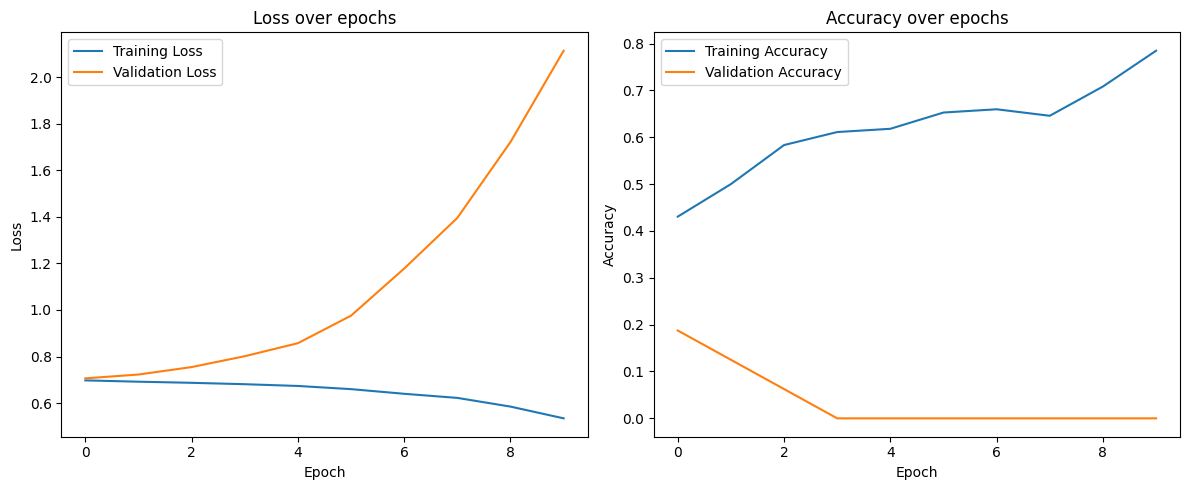

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


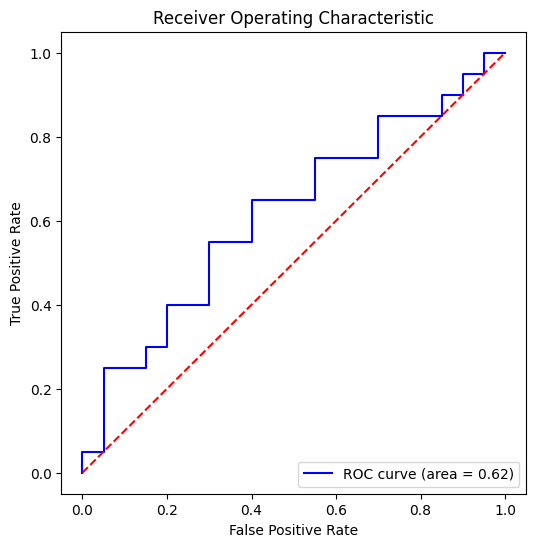

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


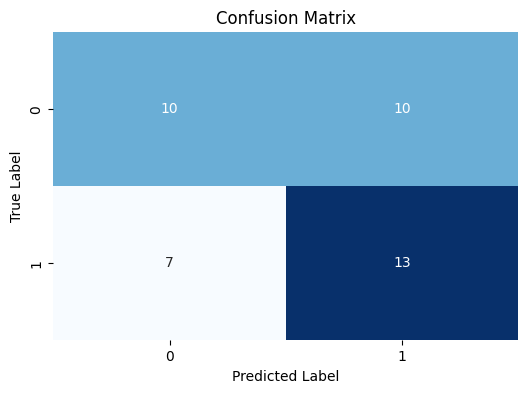

Ressource


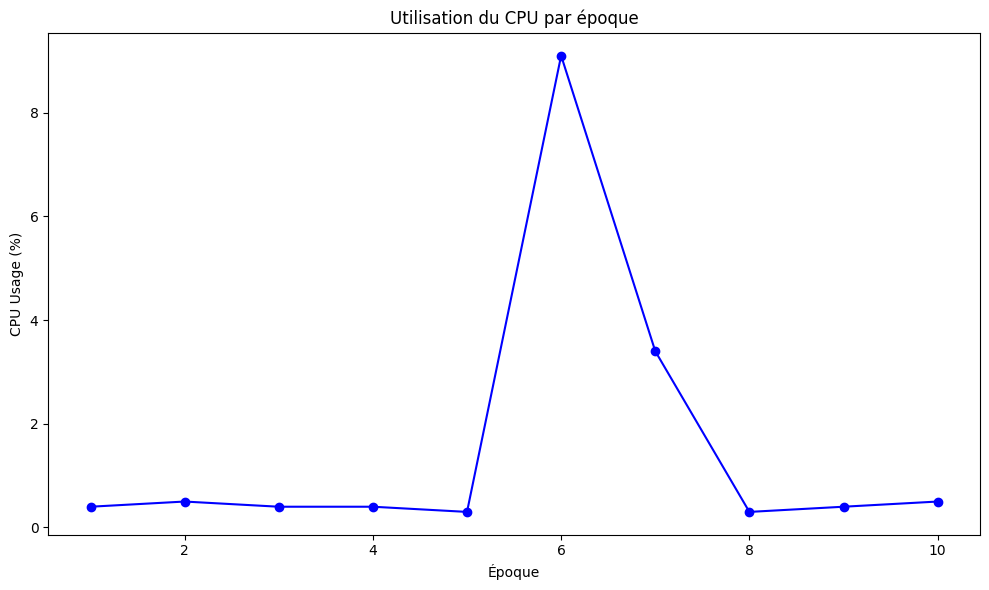

In [32]:
model_zc, history_zc = train_nn(X_train_tfidf.toarray(), train_labels, X_test_tfidf.toarray(), test_labels, epochs=10, batch_size=8)

## Complexe Neural Network

In [33]:
def prepare_data(train_texts, test_texts, vocab_size=10000, padding='post'):
    """
    Tokenise les textes et applique le padding pour obtenir des séquences de même longueur.

    Retourne :
      - X_train_pad, X_test_pad : séquences paddées pour l'entraînement et le test.
      - tokenizer : l'objet Tokenizer entraîné sur les textes d'entraînement.
      - max_length : longueur maximale utilisée pour le padding.
    """
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train_texts)
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_test_seq = tokenizer.texts_to_sequences(test_texts)

    # Définir la longueur maximale basée sur l'ensemble d'entraînement
    max_length = max(len(seq) for seq in X_train_seq)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding)

    return X_train_pad, X_test_pad, tokenizer, max_length

In [34]:
# Étape 1 : Préparation des données
vocab_size = 10000
embed_dim = 128
X_train_pad, X_test_pad, tokenizer, max_length = prepare_data(train_texts, test_texts, vocab_size=vocab_size)

In [35]:
def train_model(model, X_train, train_labels, X_test, test_labels, epochs=10, batch_size=32):
    """
    Entraîne un modèle déjà défini avec les données fournies, en utilisant un callback
    pour suivre l'utilisation des ressources par époque, et affiche ensuite les métriques d'évaluation.
    """
    resource_monitor = ResourceMonitor()

    with tf.device('/GPU:0'):
        history = model.fit(np.array(X_train), np.array(train_labels),
                        epochs=epochs, batch_size=batch_size,
                        validation_split=0.1, callbacks=[resource_monitor])



    loss, accuracy = model.evaluate(np.array(X_test), np.array(test_labels))
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    predictions = (model.predict(np.array(X_test)) > 0.5).astype("int32")
    print("\n=== Rapport de Classification ===")
    print(classification_report(np.array(test_labels), predictions))

    conf_matrix = confusion_matrix(np.array(test_labels), predictions)
    precision = precision_score(np.array(test_labels), predictions)
    recall = recall_score(np.array(test_labels), predictions)
    f1 = f1_score(np.array(test_labels), predictions)
    roc_auc = roc_auc_score(np.array(test_labels), model.predict(np.array(X_test)))

    print("Matrice de confusion :\n", conf_matrix)
    print("Précision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)

    # Afficher le graphique d'utilisation des ressources
    print('EVALUATION')
    plot_evaluation_graphs(history, model, X_test, test_labels)


    # Afficher le graphique d'utilisation des ressources
    print('Ressource utilisation')
    plot_resource_usage(resource_monitor)

    return history

### RNN

In [36]:
def build_rnn_model_1(vocab_size, embed_dim, max_length):
    """
    Construit et compile un modèle RNN simple pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences.

    Retourne :
      - model : le modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    model.add(SimpleRNN(128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [37]:
def build_rnn_model_2(vocab_size, embed_dim, max_length):
    """
    Construit un modèle RNN complexe pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    # Couche bidirectionnelle pour capturer les dépendances dans les deux sens
    model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))
    # Couche récurrente supplémentaire pour résumer la séquence
    model.add(SimpleRNN(64, activation='tanh'))
    model.add(Dropout(0.5))
    # Couches denses pour affiner la représentation
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    # Couche de sortie pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [38]:
def build_rnn_model_3(vocab_size, embed_dim, max_length):
    """
    Construit un modèle RNN complexe avec plusieurs couches récurrentes et Dense
    pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    # Couche d'embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))

    # Première couche récurrente bidirectionnelle avec retour de séquence
    model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))

    # Deuxième couche récurrente bidirectionnelle avec retour de séquence
    model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))

    # Troisième couche récurrente pour résumer la séquence
    model.add(SimpleRNN(64, activation='tanh'))

    # Dropout pour éviter le sur-apprentissage
    model.add(Dropout(0.5))

    # Couches denses supplémentaires pour approfondir la représentation
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Couche de sortie pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


#### training (100 epoch)

##### **complexity 1**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.5071 - loss: 0.7232Epoch 1 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 928ms/step - accuracy: 0.5071 - loss: 0.7228 - val_accuracy: 0.4375 - val_loss: 0.7113
Epoch 2/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4876 - loss: 0.6940Epoch 2 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.4941 - loss: 0.6933 - val_accuracy: 0.3125 - val_loss: 0.7275
Epoch 3/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6497 - loss: 0.6607Epoch 3 - CPU Usage: 0.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.6392 - loss: 0.6668 - val_accuracy: 0.7500 - val_loss: 0.6638
Epoch 4/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4655 - loss: 0.7084Epoch 4 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.4816 - loss: 0.7046 - val_accuracy: 0.1875 - val_loss: 0.7457
Epoch 5/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4375 - loss: 0.7316Epoch 5 - CPU Usage:

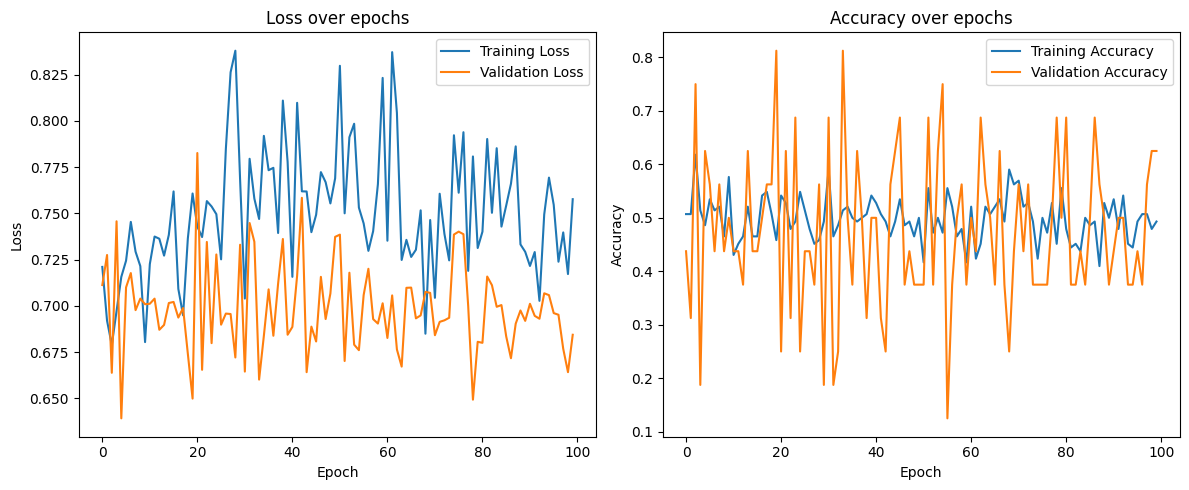

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


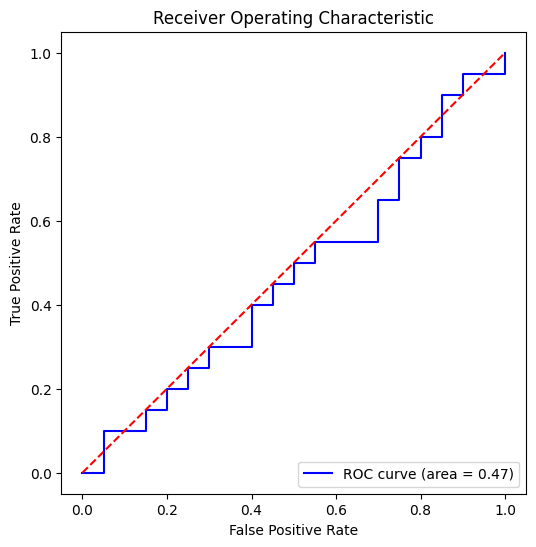

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


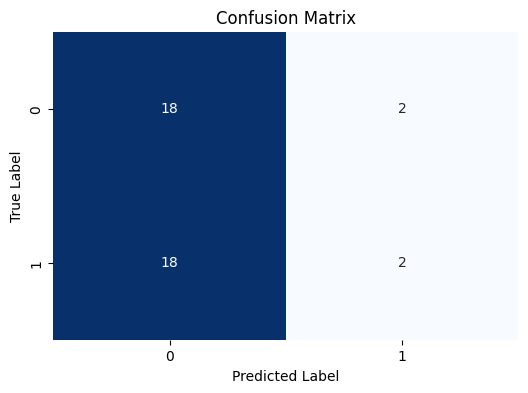

Ressource utilisation


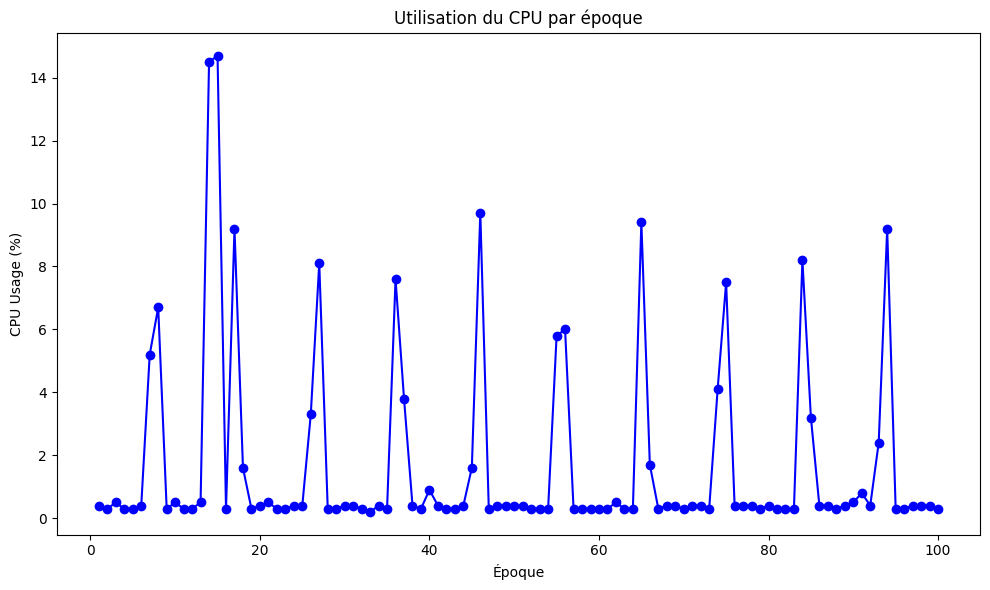

In [39]:
# Étape 3 : Entraînement du modèle avec suivi des ressources
model_rnn_1 = build_rnn_model_1(vocab_size, embed_dim, max_length)
history_rnn_1 = train_model(model_rnn_1, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

##### **complexity 2**


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.4443 - loss: 0.8613Epoch 1 - CPU Usage: 7.6%
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4466 - loss: 0.8583 - val_accuracy: 0.5000 - val_loss: 0.6976
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4434 - loss: 0.7717Epoch 2 - CPU Usage: 2.1%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.4482 - loss: 0.7698 - val_accuracy: 0.5000 - val_loss: 0.7005
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4035 - loss: 0.7868Epoch 3 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.4068 - loss: 0.7881 - val_accuracy: 0.4375 - val_loss: 0.7351
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4906 - loss: 0.7385Epoch 4 - CPU Usage: 0.6%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.4852 - loss: 0.7396 - val_accuracy: 0.4375 - val_loss: 0.7295
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4714 - loss: 0.7756Epoch 5 - CPU Usage: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step

=== Rapport de Classification ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Matrice de confusion :
 [[ 0 20]
 [ 0 20]]
Précision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666
ROC AUC: 0.52125
EVALUATION


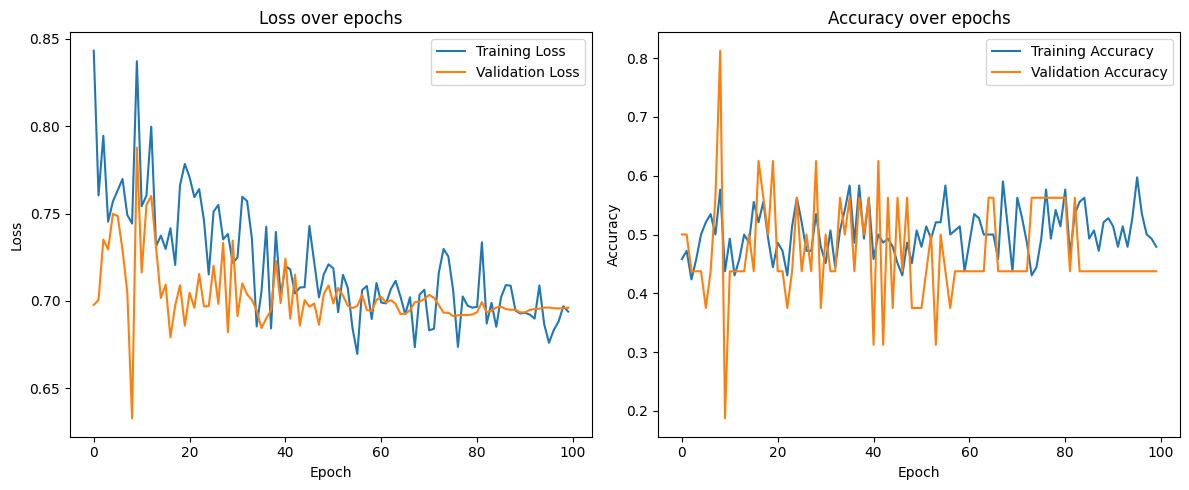

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


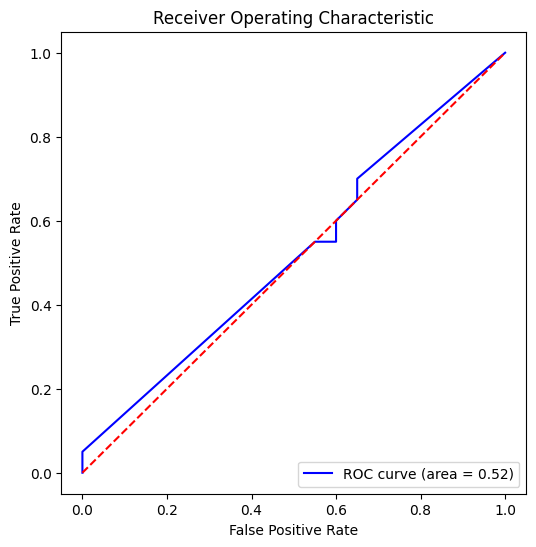

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


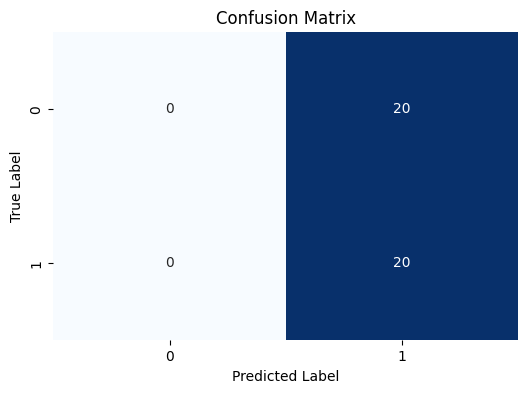

Ressource utilisation


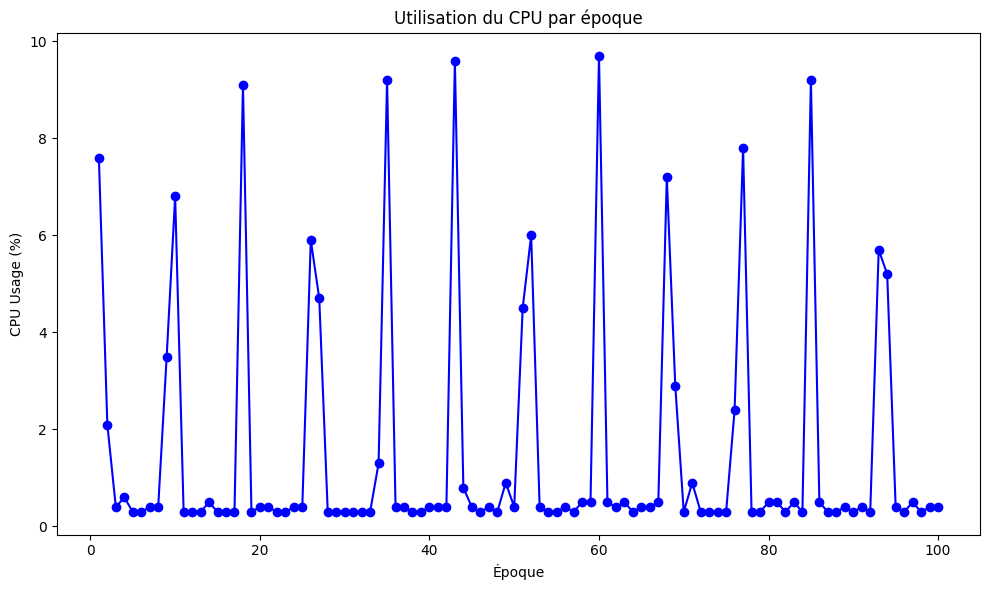

In [40]:
model_rnn_2 = build_rnn_model_2(vocab_size, embed_dim, max_length)
history_rnn_2 = train_model(model_rnn_2, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

#####**Complexity 3**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.5227 - loss: 0.7847Epoch 1 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5166 - loss: 0.7928 - val_accuracy: 0.4375 - val_loss: 0.7334
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5734 - loss: 0.7104Epoch 2 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.5612 - loss: 0.7211 - val_accuracy: 0.4375 - val_loss: 0.7973
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5073 - loss: 0.7221Epoch 3 - CPU Usage: 0.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.5095 - loss: 0.7227 - val_accuracy: 0.4375 - val_loss: 0.7495
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4465 - loss: 0.8510Epoch 4 - CPU Usage: 0.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.4439 - loss: 0.8525 - val_accuracy: 0.4375 - val_loss: 0.7351
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4832 - loss: 0.7902Epoch 5 - CPU Usage: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

=== Rapport de Classification ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Matrice de confusion :
 [[ 0 20]
 [ 0 20]]
Précision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666
ROC AUC: 0.6950000000000001
EVALUATION


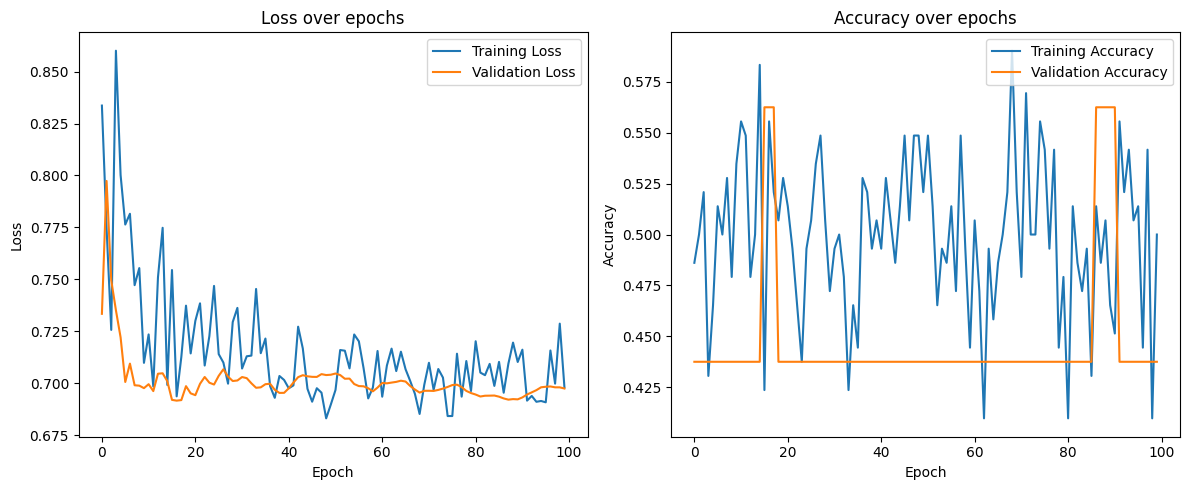

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


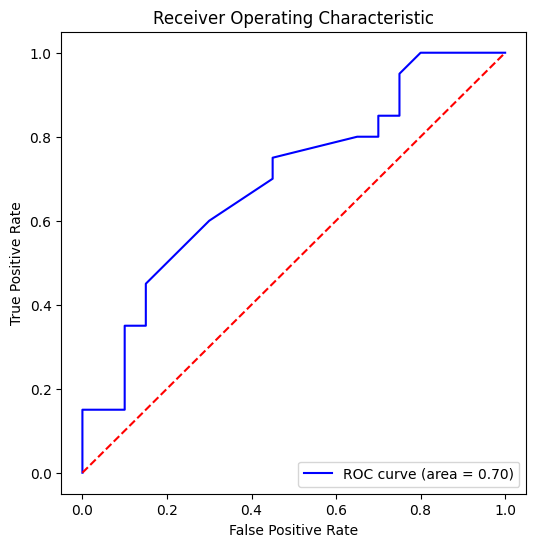

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


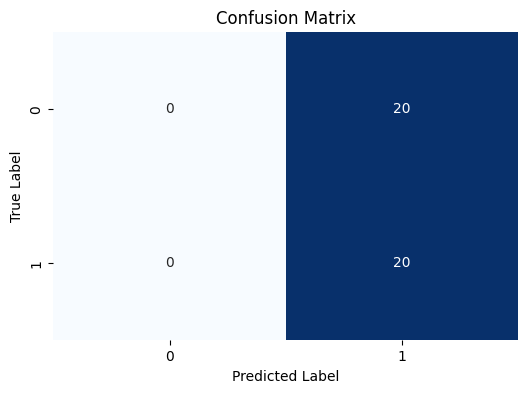

Ressource utilisation


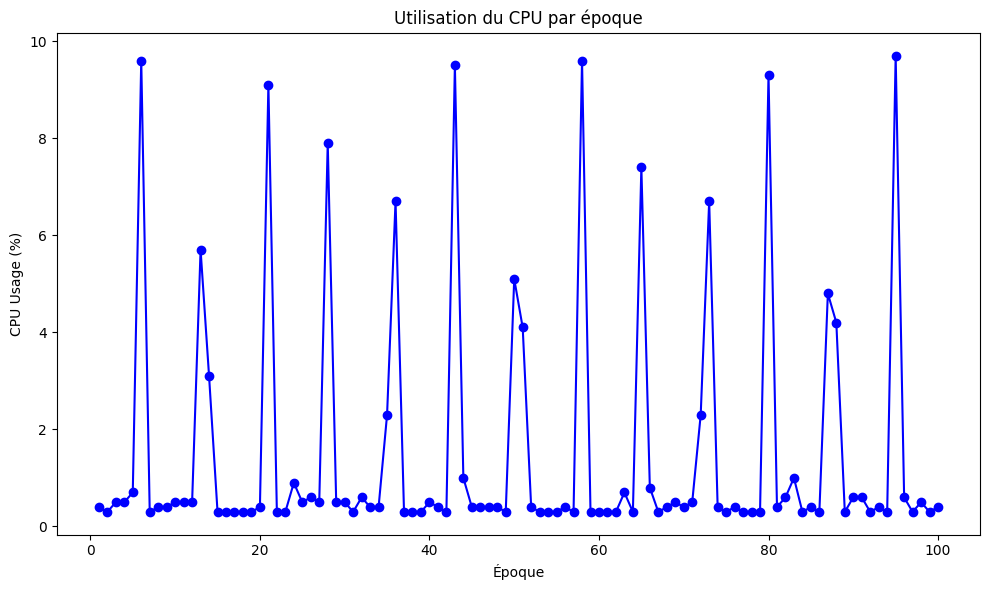

In [43]:
model_rnn_3 = build_rnn_model_3(vocab_size, embed_dim, max_length)
history_rnn_3 = train_model(model_rnn_3, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

##### conclusion

### LSTM

In [44]:
def build_lstm_model_1(vocab_size, embed_dim, max_length):
    """
    Construit et compile un modèle LSTM simple pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences.

    Retourne :
      - model : le modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [45]:
def build_lstm_model_2(vocab_size, embed_dim, max_length):
    """
    Construit un modèle LSTM complexe pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    # Première couche LSTM bidirectionnelle avec return_sequences pour empiler une deuxième couche
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    # Deuxième couche LSTM bidirectionnelle
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [46]:
def build_lstm_model_3(vocab_size, embed_dim, max_length):
    """
    Construit un modèle LSTM complexe avec plusieurs couches LSTM empilées
    et Dense pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    # Couche d'embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))

    # Première couche LSTM bidirectionnelle avec retour de séquence
    model.add(Bidirectional(LSTM(128, return_sequences=True)))

    # Deuxième couche LSTM bidirectionnelle avec retour de séquence
    model.add(Bidirectional(LSTM(128, return_sequences=True)))

    # Troisième couche LSTM bidirectionnelle pour résumer la séquence
    model.add(Bidirectional(LSTM(64)))

    # Dropout pour la régularisation
    model.add(Dropout(0.5))

    # Couches denses supplémentaires
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Couche de sortie pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### training (100 epochs)

#####**complexity 1**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4958 - loss: 0.6946Epoch 1 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.4931 - loss: 0.6948 - val_accuracy: 0.4375 - val_loss: 0.6957
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5365 - loss: 0.6921Epoch 2 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.5339 - loss: 0.6924 - val_accuracy: 0.4375 - val_loss: 0.6978
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4689 - loss: 0.6962Epoch 3 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.4764 - loss: 0.6958 - val_accuracy: 0.5625 - val_loss: 0.6919
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5049 - loss: 0.6955Epoch 4 - CPU Usage: 5.0%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.4994 - loss: 0.6958 - val_accuracy: 0.4375 - val_loss: 0.6965
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5266 - loss: 0.6947Epoch 5 - CPU Usage: 

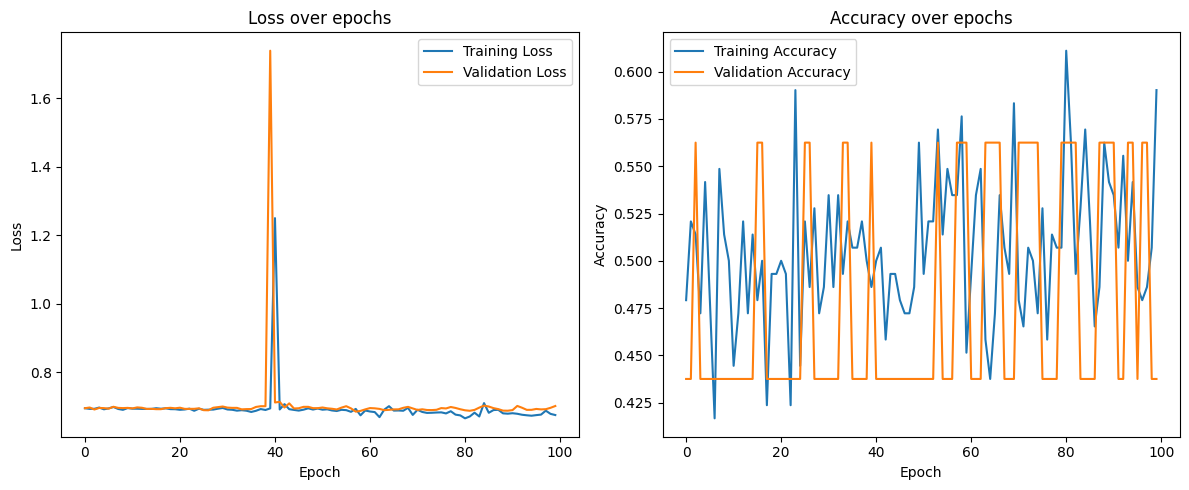

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


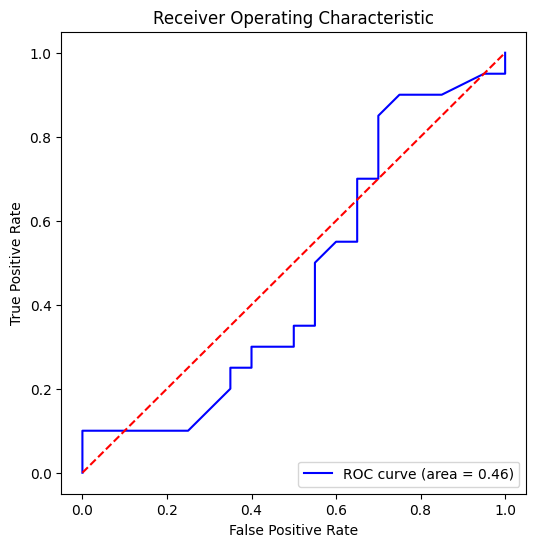

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


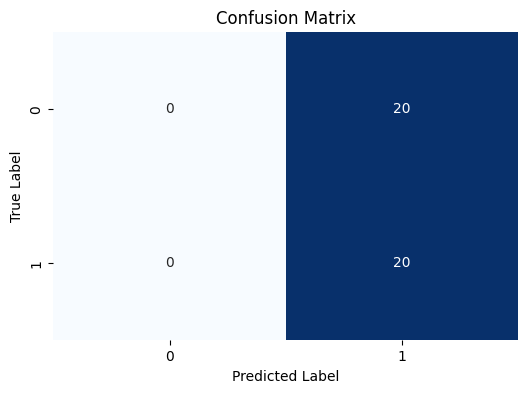

Ressource utilisation


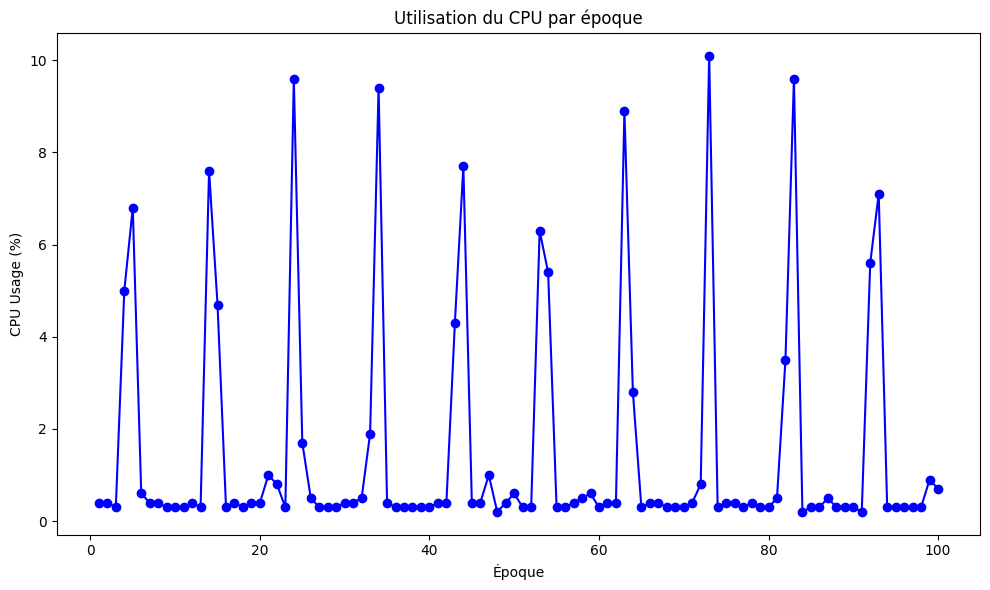

In [47]:
model_lstm_1 = build_lstm_model_1(vocab_size, embed_dim, max_length)
history_lstm_1 = train_model(model_lstm_1, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

#####**Complexity 2**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5738 - loss: 0.6932Epoch 1 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/step - accuracy: 0.5661 - loss: 0.6938 - val_accuracy: 0.5625 - val_loss: 0.6918
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4990 - loss: 0.6945Epoch 2 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.4991 - loss: 0.6942 - val_accuracy: 0.4375 - val_loss: 0.6997
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4851 - loss: 0.6919Epoch 3 - CPU Usage: 0.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.4829 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.7074
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4800 - loss: 0.7029Epoch 4 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.4845 - loss: 0.7020 - val_accuracy: 0.4375 - val_loss: 0.7145
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5377 - loss: 0.6872Epoch 5 - CPU Usage: 

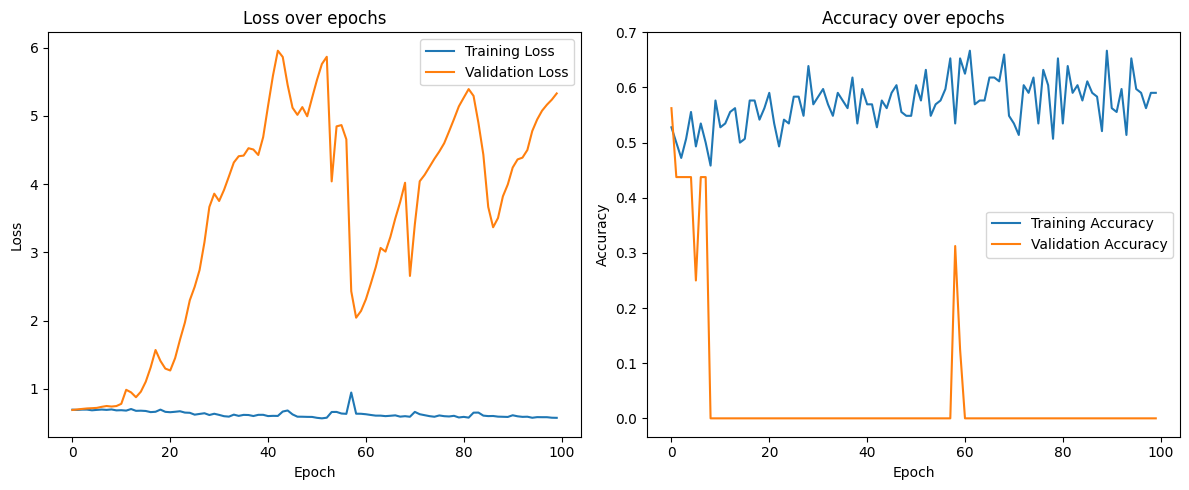

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


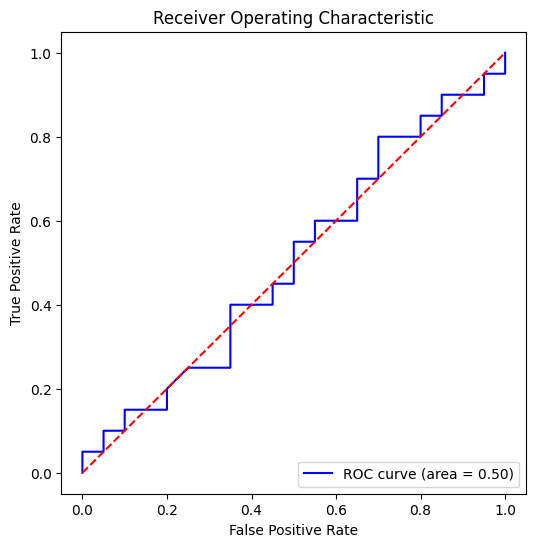

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


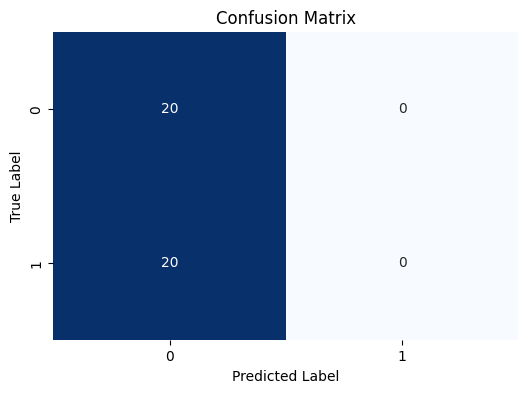

Ressource utilisation


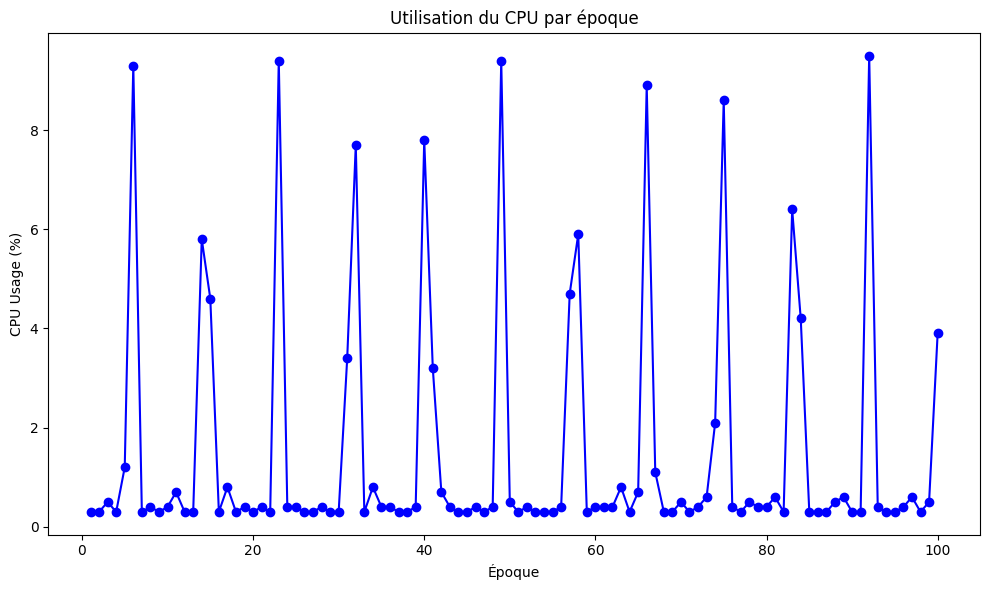

In [48]:
model_lstm_2 = build_lstm_model_2(vocab_size, embed_dim, max_length)
history_lstm_2 = train_model(model_lstm_2, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

#####**Complexity 3**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5069 - loss: 0.6955Epoch 1 - CPU Usage: 0.2%
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 506ms/step - accuracy: 0.5012 - loss: 0.6960 - val_accuracy: 0.5625 - val_loss: 0.6932
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4821 - loss: 0.6954Epoch 2 - CPU Usage: 7.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.4828 - loss: 0.6953 - val_accuracy: 0.5625 - val_loss: 0.6926
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4259 - loss: 0.6999Epoch 3 - CPU Usage: 1.9%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.4359 - loss: 0.6988 - val_accuracy: 0.5625 - val_loss: 0.6927
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5802 - loss: 0.6906Epoch 4 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.5773 - loss: 0.6908 - val_accuracy: 0.5625 - val_loss: 0.6900
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4705 - loss: 0.7021Epoch 5 - CPU Usage: 

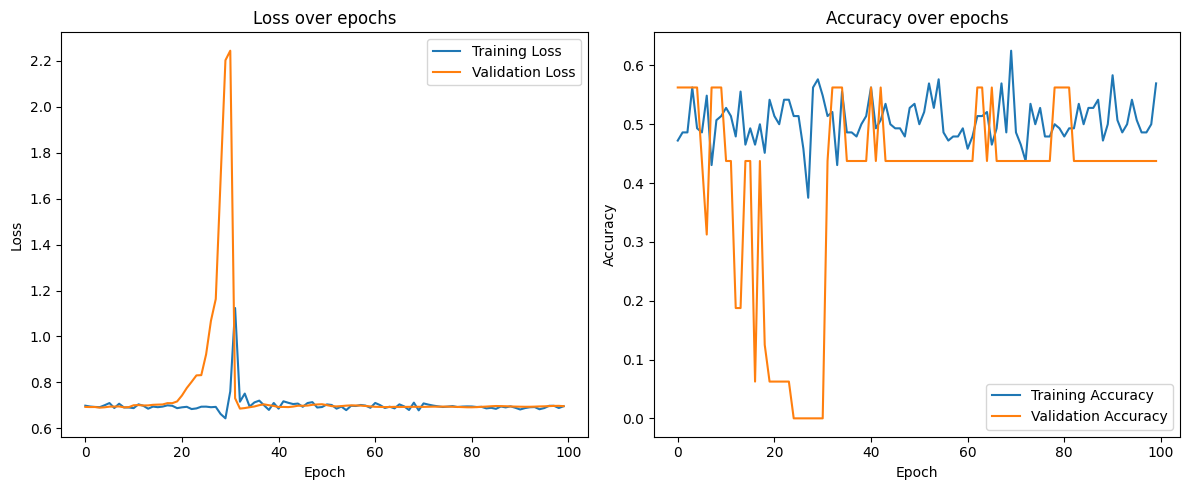

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


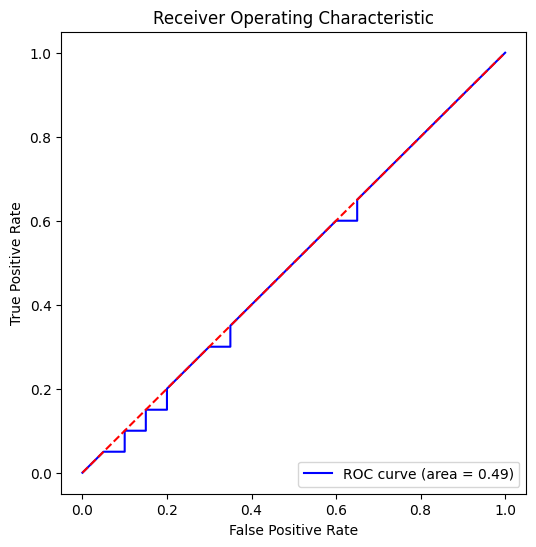

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


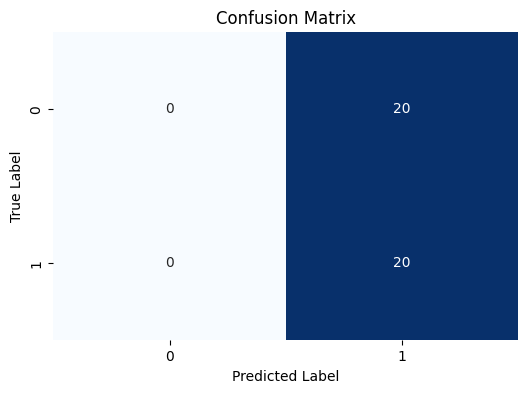

Ressource utilisation


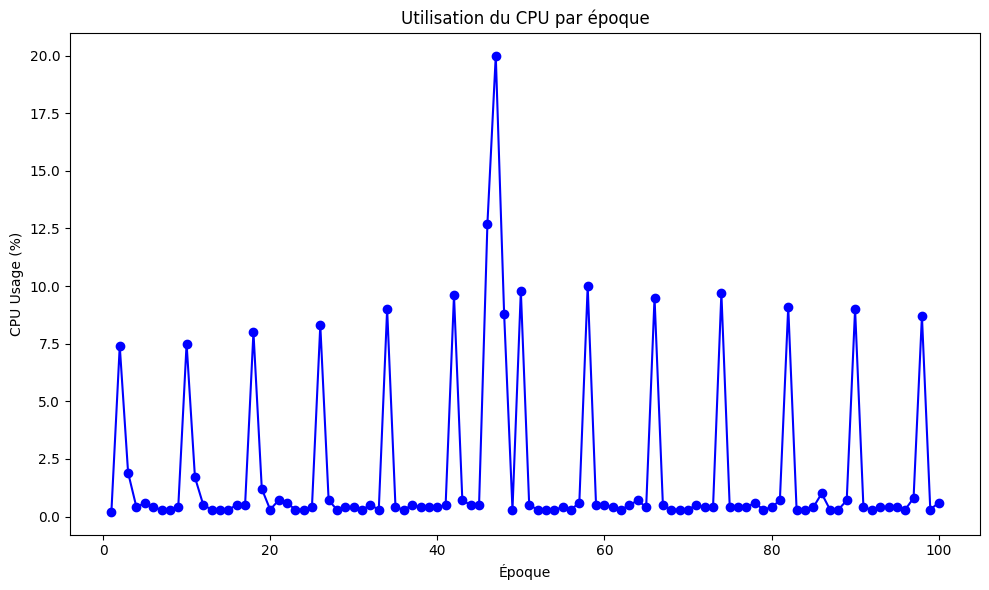

In [49]:
model_lstm_3 = build_lstm_model_3(vocab_size, embed_dim, max_length)
history_lstm_3 = train_model(model_lstm_3, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

# **Transformer**

## Class: **TextDataset**

In [50]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## evaluation metrics

In [51]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


## load dataset

In [52]:
def load_model_and_tokenizer(model_id, num_labels=2):
    """
    Charge le modèle pré-entraîné et le tokenizer correspondant.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)
    return model, tokenizer

## create dataset

In [53]:
def create_datasets(train_texts, train_labels, test_texts, test_labels, tokenizer, max_length=256):
    """
    Crée les datasets d'entraînement et de test.
    """
    train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length)
    test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_length)
    return train_dataset, test_dataset

## Finetune

In [54]:
def fine_tune_model(model_id, train_texts, train_labels, test_texts, test_labels, training_args, max_length=256):
    """
    Fine-tune un modèle Transformer pour la classification de textes.

    Retourne :
      - eval_results : résultats d'évaluation après entraînement.
      - model : modèle fine-tuné.
      - trainer : instance du Trainer utilisée.
    """
    model, tokenizer = load_model_and_tokenizer(model_id)
    train_dataset, test_dataset = create_datasets(train_texts, train_labels, test_texts, test_labels, tokenizer, max_length)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results, model, trainer

## Test model

In [55]:
def test_models(model_dict, train_texts, train_labels, test_texts, test_labels, training_args, max_length=256):
    """
    Itère sur un dictionnaire de modèles et fine-tune chacun d'entre eux.

    Paramètres :
      - model_dict : dictionnaire avec comme clés les identifiants de modèle et comme valeurs des étiquettes lisibles.
      - train_texts, train_labels, test_texts, test_labels : données de classification.
      - training_args : arguments d'entraînement pour Hugging Face Trainer.
      - max_length : longueur maximale pour le padding des séquences.

    Retourne un dictionnaire de résultats d'évaluation pour chaque modèle.
    """
    results = {}
    for model_id, model_label in model_dict.items():
        print("\n==============================================")
        print("Fine-tuning du modèle :", model_label)
        print("==============================================")
        eval_results, model, trainer = fine_tune_model(
            model_id, train_texts, train_labels, test_texts, test_labels, training_args, max_length
        )
        print(f"Résultats d'évaluation pour {model_label} :", eval_results)
        results[model_label] = eval_results
    return results

## config

In [56]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",          # Ajouté pour correspondre à evaluation_strategy
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Dictionnaire des modèles à tester
model_names = {
    "bert-base-uncased": "BERT",
    "distilbert-base-uncased": "DistilBERT",
    "roberta-base": "RoBERTa"
}

In [57]:

for model_id, model_label in model_names.items():
    print("\n==============================================")
    print("Fine-tuning du modèle :", model_label)
    print("==============================================")

    # Chargement du tokenizer et du modèle pré-entraîné
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

    # Préparation des datasets
    train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length=256)
    test_dataset  = TextDataset(test_texts, test_labels, tokenizer, max_length=256)

    # Création du Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Fine-tuning
    trainer.train()

    # Évaluation
    eval_results = trainer.evaluate()
    print(f"Résultats d'évaluation pour {model_label} :", eval_results)


Fine-tuning du modèle : BERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bokambaregis to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.729000,0.693394,0.500000,0.500000,1.000000,0.666667
2,0.692700,0.691157,0.650000,0.750000,0.450000,0.562500
3,0.705900,0.692030,0.525000,0.666667,0.100000,0.173913


Résultats d'évaluation pour BERT : {'eval_loss': 0.6911570429801941, 'eval_accuracy': 0.65, 'eval_precision': 0.75, 'eval_recall': 0.45, 'eval_f1': 0.5625, 'eval_runtime': 0.2602, 'eval_samples_per_second': 153.706, 'eval_steps_per_second': 3.843, 'epoch': 3.0}

Fine-tuning du modèle : DistilBERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.703700,0.692912,0.550000,0.666667,0.200000,0.307692
2,0.691800,0.693032,0.500000,0.000000,0.000000,0.000000
3,0.695500,0.692993,0.500000,0.000000,0.000000,0.000000


Résultats d'évaluation pour DistilBERT : {'eval_loss': 0.6929123997688293, 'eval_accuracy': 0.55, 'eval_precision': 0.6666666666666666, 'eval_recall': 0.2, 'eval_f1': 0.3076923076923077, 'eval_runtime': 0.1237, 'eval_samples_per_second': 323.292, 'eval_steps_per_second': 8.082, 'epoch': 3.0}

Fine-tuning du modèle : RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.696200,0.693087,0.500000,0.000000,0.000000,0.000000
2,0.696800,0.692947,0.500000,0.000000,0.000000,0.000000
3,0.692400,0.692968,0.500000,0.000000,0.000000,0.000000


Résultats d'évaluation pour RoBERTa : {'eval_loss': 0.6930872201919556, 'eval_accuracy': 0.5, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 0.2526, 'eval_samples_per_second': 158.372, 'eval_steps_per_second': 3.959, 'epoch': 3.0}


##**Hyperparameters**